In [17]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from collections import Counter
import seaborn as sns
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=170, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = '/home/ucsd-train01/single_cell_results/PBMCs3000.h5ad'
results_file_denoised = '/home/ucsd-train01/single_cell_results/PBMCs3000_deno.h5ad'

scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.24.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


We are going to use Scanpy's "read_10x_mtx" function because we are reading in a 10X mtx file to analyze. We could also start with a matrix generated from FeatureCounts or DESeq2 or any other program. To do this we could use the python package pandas like this:

In [18]:
# store the dataframe as Liu_All
Liu_All=pd.read_csv('/oasis/tscc/scratch/biom200/cmm262/Module_4_2020/Notebooks/GSE89497_Human_Placenta_TMP_V3.txt', delimiter = '\t', index_col=0)

#Print the size of the dataframe (number of rows and columns)
print(Liu_All.shape)

#look at the first 5 rows
Liu_All.head()

(24910, 1567)


,HE24W_EVT_sc1,HE24W_EVT_sc10,HE24W_EVT_sc100,HE24W_EVT_sc101,HE24W_EVT_sc102,HE24W_EVT_sc103,HE24W_EVT_sc104,HE24W_EVT_sc105,HE24W_EVT_sc106,HE24W_EVT_sc107,...,HE8W_STR_sc90,HE8W_STR_sc91,HE8W_STR_sc92,HE8W_STR_sc93,HE8W_STR_sc94,HE8W_STR_sc95,HE8W_STR_sc96,HE8W_STR_sc97,HE8W_STR_sc98,HE8W_STR_sc99
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,1.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.82,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,63.76,0.00
A1BG-AS1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
A1CF,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00
A2M,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,7.35,0.0,0.0,0.0,0.0,58.45,110.63
A2M-AS1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00


Select genes and samples for analysis

There is A LOT of zeros in single cell data. Current rough estimates are that only ~10% of the transcriptome is acutally measured in each single cell. Therefore, it is important to only keep the genes for analysis that were detected in enough cells for us to gain meaningful information about them. A commonly used cutoff is to keep genes that were detected with at lest 1 UMI count in 10% of cells. Let's subset this dataframe for only those genes.

In [19]:
# Is the UMI count greater than 0 (at least 1). 
# I am going to wrap thisthis function in head to make it easy to view the result

(Liu_All > 0).head()

,HE24W_EVT_sc1,HE24W_EVT_sc10,HE24W_EVT_sc100,HE24W_EVT_sc101,HE24W_EVT_sc102,HE24W_EVT_sc103,HE24W_EVT_sc104,HE24W_EVT_sc105,HE24W_EVT_sc106,HE24W_EVT_sc107,...,HE8W_STR_sc90,HE8W_STR_sc91,HE8W_STR_sc92,HE8W_STR_sc93,HE8W_STR_sc94,HE8W_STR_sc95,HE8W_STR_sc96,HE8W_STR_sc97,HE8W_STR_sc98,HE8W_STR_sc99
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
A1BG-AS1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A1CF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A2M,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,True
A2M-AS1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Notice the result is a True/False (boolean) of whether or not the condition was satisfied. We are going to use .sum to count the number of True values in each row. The number of true values for each gene will tell us how many cells had a count of > 0 for that gene.

In [20]:
#Axis = 1 calculates the sum across the rows (genes) instead of columns (cells)
#Again, using head to only look at the first 5 results. 

(Liu_All > 0).sum(axis=1).head()

Gene
A1BG        429
A1BG-AS1      9
A1CF         11
A2M         426
A2M-AS1      15
dtype: int64

We are interested in genes that were detected in at least 10% of cells. So we need genes where the sum that we just calculated is at least 10% of the total number of cells we have. First lets get the number corresponding to 10% of the cells.
Before we go further we need to be sure that we are going to keep all of the cells that are currently in the matrix. Lets say we didn't want any of the stromal cells which have "STR" in their name. To filter out just these cells we can do: 

In [21]:
Liu_All = pd.DataFrame(Liu_All)
Liu_All = Liu_All[Liu_All.columns.drop(list(Liu_All.filter(regex='STR')))]
Liu_All.head()
print(Liu_All.shape)

(24910, 952)


In [22]:
#all the cell IDs are stored in the columns of our dataframe, 
#so we can get the total number of cells by finding the length of the columns

num_cells = len(Liu_All.columns)
0.1*num_cells

95.2

In [23]:
#now ask how many of those genes have a sum greater than 0.1% times the number of cells

((Liu_All > 0).sum(axis=1) > 0.1*num_cells).head()

Gene
A1BG         True
A1BG-AS1    False
A1CF        False
A2M         False
A2M-AS1     False
dtype: bool

In [24]:
#We are going to store this boolean result as the variable genes_to_keep:

genes_to_keep = (Liu_All > 0).sum(axis=1) > 0.1*num_cells
genes_to_keep.head()

Gene
A1BG         True
A1BG-AS1    False
A1CF        False
A2M         False
A2M-AS1     False
dtype: bool

Now subset the dataframe to only keep genes that have the True value.

In [25]:
counts_filtered = Liu_All.loc[genes_to_keep]

#How many genes are we left with?
print(counts_filtered.shape)
counts_filtered.head()

(11973, 952)


,HE24W_EVT_sc1,HE24W_EVT_sc10,HE24W_EVT_sc100,HE24W_EVT_sc101,HE24W_EVT_sc102,HE24W_EVT_sc103,HE24W_EVT_sc104,HE24W_EVT_sc105,HE24W_EVT_sc106,HE24W_EVT_sc107,...,HE8W_STB_sc59,HE8W_STB_sc6,HE8W_STB_sc60,HE8W_STB_sc61,HE8W_STB_sc62,HE8W_STB_sc63,HE8W_STB_sc64,HE8W_STB_sc7,HE8W_STB_sc8,HE8W_STB_sc9
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,1.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.82,...,0.00,0.00,0.00,1.28,0.0,0.00,1.5,0.00,0.00,1.82
A4GALT,32.62,22.24,0.00,25.89,28.46,25.33,9.41,31.10,28.20,34.35,...,0.00,3.23,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.61
AAAS,29.90,25.21,0.00,36.98,18.97,39.31,21.51,34.99,26.44,25.45,...,0.00,8.62,0.00,1.28,0.0,0.00,12.0,4.66,22.30,12.71
AACS,24.46,57.83,100.71,48.08,14.23,37.56,10.76,19.44,42.30,20.36,...,20.61,7.54,2.87,2.55,0.0,11.57,0.0,7.77,6.86,0.61
AADACL2-AS1,0.00,1.48,0.00,2.47,0.00,0.87,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,1.5,0.00,0.00,1.82


How many UMIs are detected per cell?

In this dataframe, the number of UMIs detected is the sum of the columns. Remember we summed the rows before. How do you get the column sums? Change the axis level!

In [26]:
counts_filtered.sum(axis=0).head()

HE24W_EVT_sc1      997880.60
HE24W_EVT_sc10     997807.26
HE24W_EVT_sc100    997642.93
HE24W_EVT_sc101    998302.17
HE24W_EVT_sc102    998409.26
dtype: float64

Let's make a histogram of these counts so we can see how many UMIs are expressed in all of our cells.

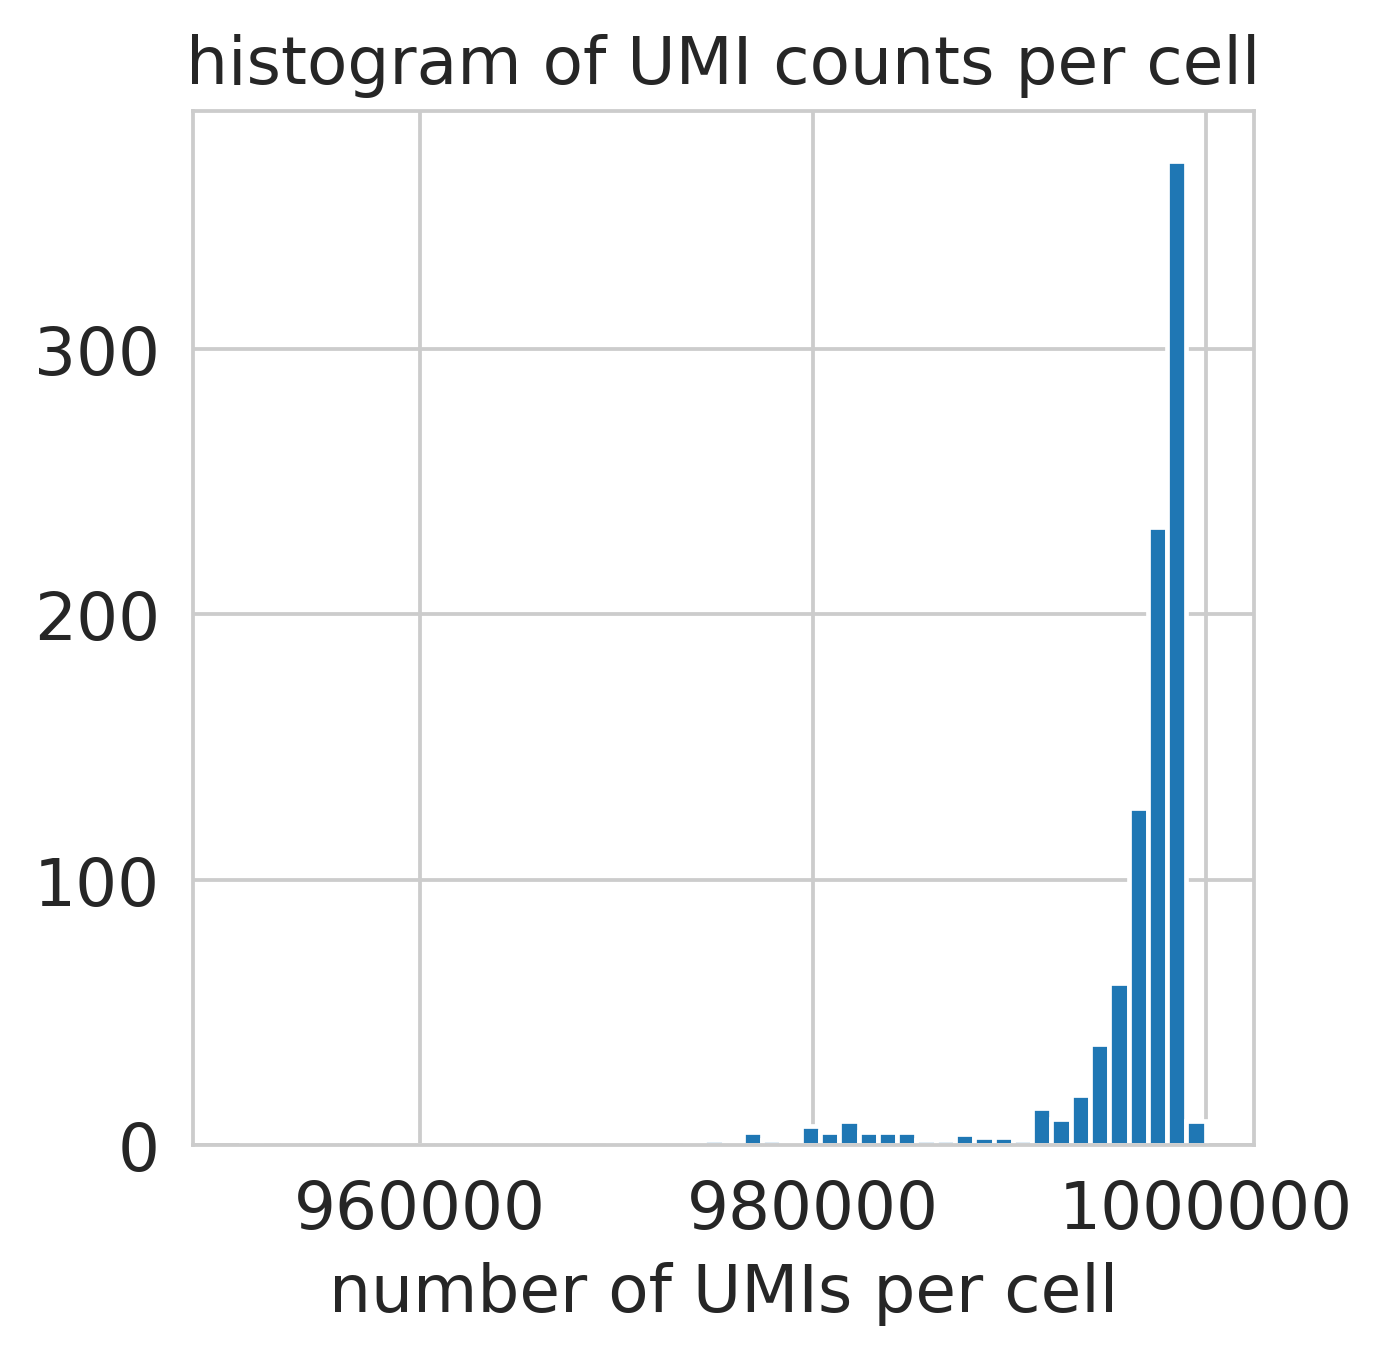

In [27]:
#make the background color white (default is grey)
sns.set_style("whitegrid")

#Histogram of the sums we calculated above. Increase the number of bins for higher resolution.
#What happens if you use different bin sizes? Try it out!
plt.hist(counts_filtered.sum(axis=0), bins=50)

#Give the plot an xlabel and a title
plt.xlabel("number of UMIs per cell")
plt.title('histogram of UMI counts per cell')

#This will prevent any text from being printed out other than your plot. 
#Sometimes these functions automatically print a lot of things that are annoying.
plt.show()

Do these counts look reasonable? Are there any cells that we should filter out? We can also display this as a boxplot. Or a voilinplot. Check out the code below.

Text(0, 0.5, 'UMI counts per cell')

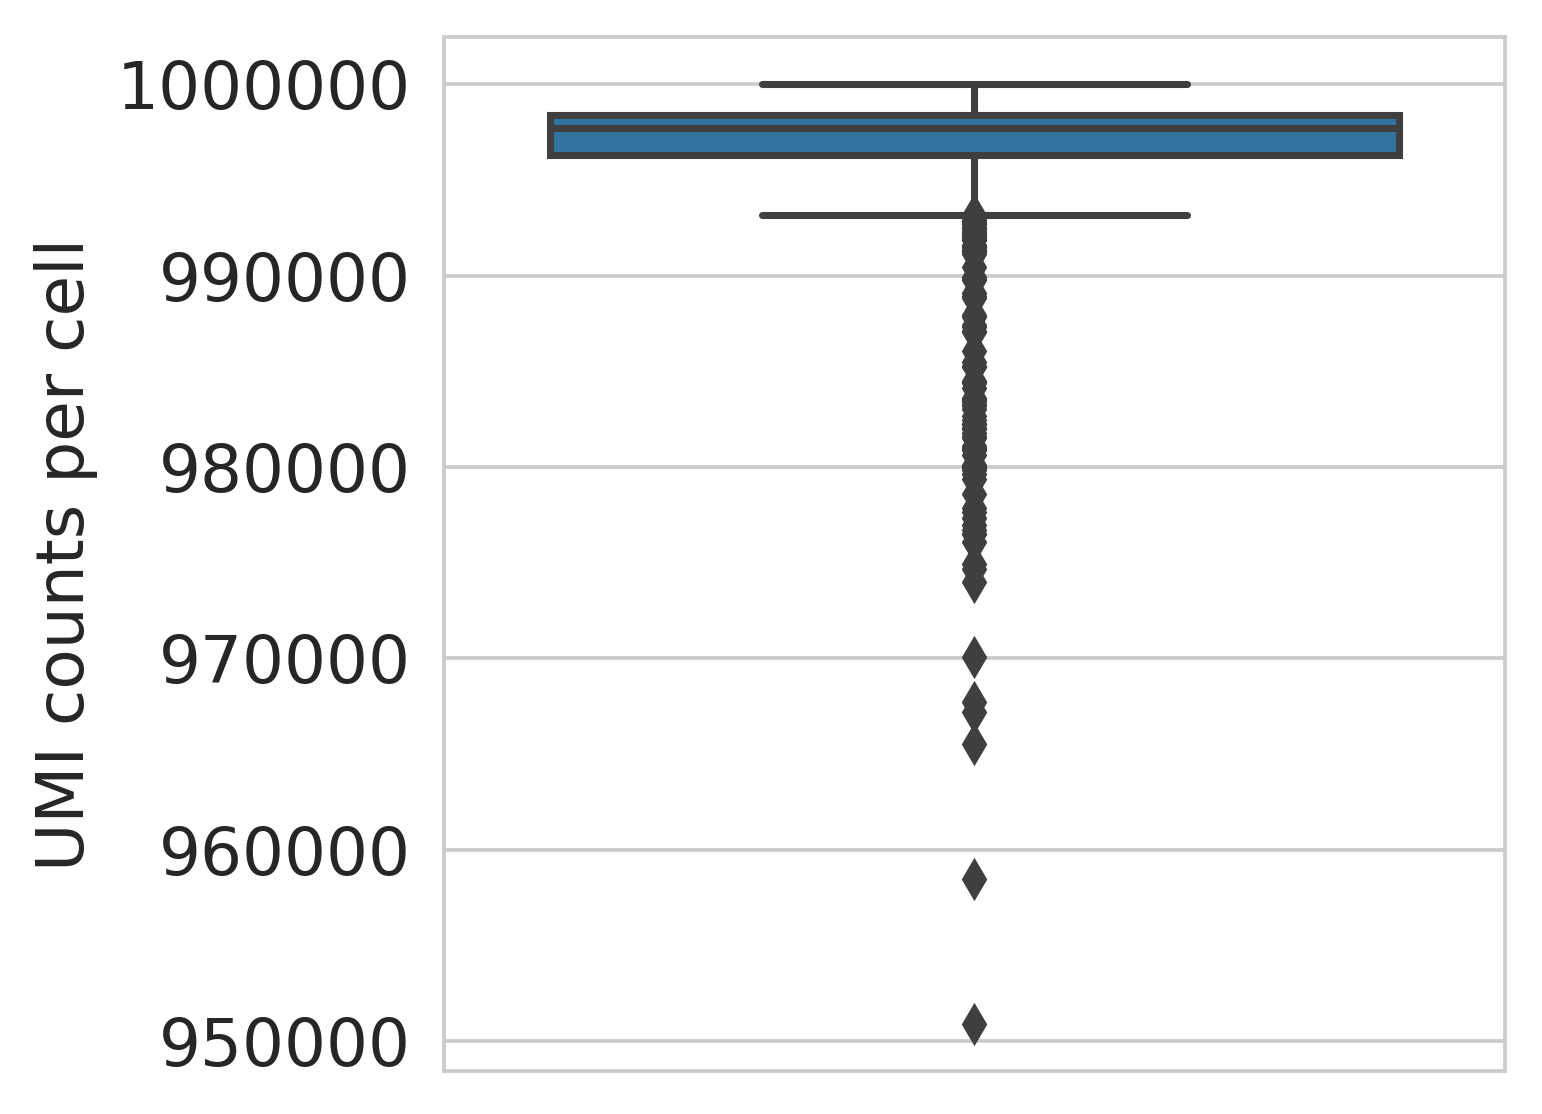

In [28]:
#Making axis labels with seaborn plots is a little different. 
#We are going to call the graph that we made g. then set_ylabel on g

g = sns.boxplot(counts_filtered.sum(axis=0), orient='v')
g.set_ylabel("UMI counts per cell")

Text(0, 0.5, 'UMI counts per cell')

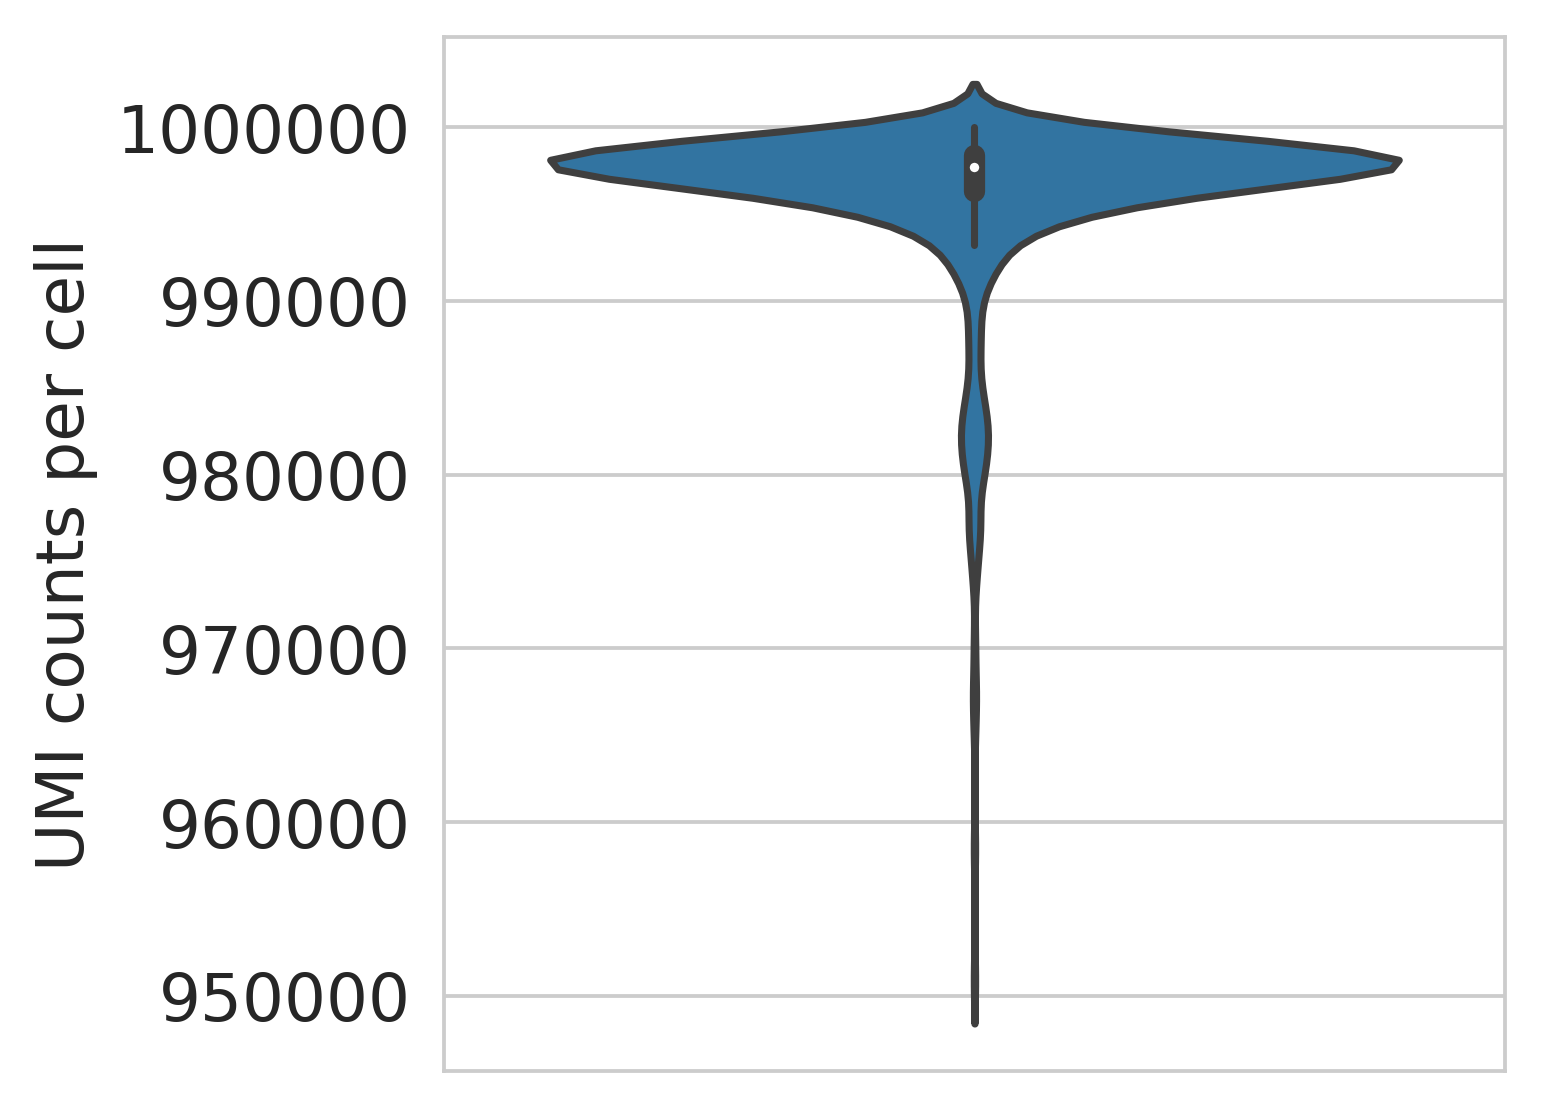

In [29]:
g = sns.violinplot(counts_filtered.sum(axis=0), orient='v')
g.set_ylabel("UMI counts per cell")

Exercise

Make a histogram, boxplot, and violoinplot for the total counts measured for each gene (instead of cells). What do you notice?

Save Filtered DataFrame

Let's save this new matrix as counts_filtered so we can load it in later for downstream analyses. We will use the pandas function to_csv

In [30]:
save_dir = "/home/ucsd-train01/single_cell_results/"

counts_filtered.to_csv(save_dir+"counts_filtered.csv")